### Library import

In [1]:
import sys
import os
import serial
import csv
import time
import pandas as pd
import functools
import numpy as np
import random as rd
import matplotlib
import threading
from numpy import diff
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure

plt.rcParams["figure.figsize"] = (20,3)
import helpers

In [13]:
#---- CNN model libraries ----
import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras import callbacks
from keras import backend as K
from keras.models import load_model

import object_location

2025-09-24 19:24:25.154173: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
plt.rcParams["figure.figsize"] = (20,3)

### Functions

In [15]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Data capture

Iniciando captura de datos...
Esperando datos del sensor 1...
Recibiendo datos del sensor 1...
Esperando datos del sensor 2...
Recibiendo datos del sensor 2...
Esperando datos del sensor 3...
Recibiendo datos del sensor 3...
Captura finalizada. Puerto serial cerrado.


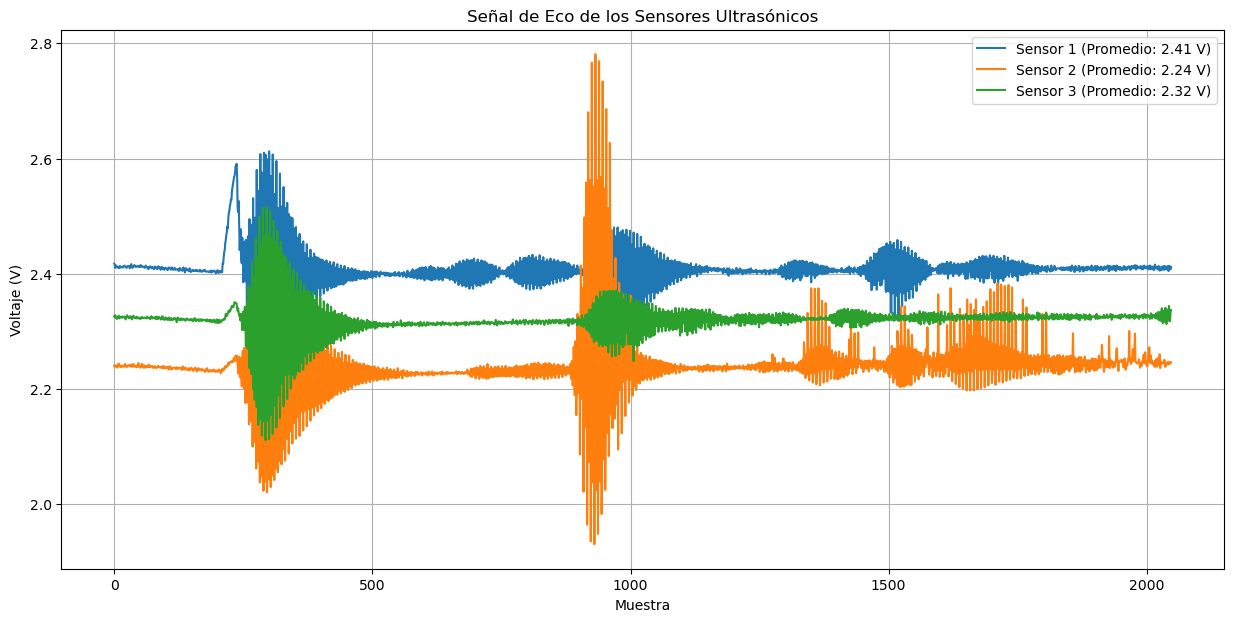

In [6]:
# --- Constantes ---
SERIAL_PORT = '/dev/ttyACM0'
BAUDRATE = 250000
SERIAL_LENGTH = 2048  # Número de muestras de voltaje por sensor
N_SENSORS = 3        # Número de sensores
file_version_number = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
save_file = True

# --- Inicializar Tensor de Datos ---
# Usamos np.nan (Not a Number) para identificar fácilmente si faltaron datos
received_data = np.full((N_SENSORS, SERIAL_LENGTH), np.nan)

print("Iniciando captura de datos...")

# Usar 'with' asegura que el puerto serial se cierre automáticamente
with serial.Serial(SERIAL_PORT, baudrate=BAUDRATE, timeout=1) as ser:
    # Darle tiempo al Arduino para que se reinicie si es necesario
    time.sleep(0.3)
    ser.flushInput()

    for j in range(N_SENSORS):
        print(f"Esperando datos del sensor {j+1}...")
        
        # 1. SINCRONIZAR: Esperar el encabezado de inicio de datos del sensor
        while True:
            line = ser.readline().decode('utf-8', errors='ignore').strip()
            if f"Datos del Sensor {j+1}" in line:
                print(f"Recibiendo datos del sensor {j+1}...")
                break
        
        # 2. CAPTURAR: Leer la cantidad esperada de muestras de voltaje
        temp_data = []
        for k in range(SERIAL_LENGTH):
            try:
                line = ser.readline().decode('utf-8', errors='ignore').strip()
                # 3. CONVERTIR: Intentar convertir la línea a un número flotante
                voltage = float(line)
                temp_data.append(voltage)
            except (ValueError, IndexError):
                # Si la línea está vacía o no es un número, la ignoramos y continuamos
                print(f"Advertencia: Se recibió una línea inválida: '{line}'")
                temp_data.append(np.nan) # Agregar un marcador de dato inválido

        # Almacenar los datos capturados
        if len(temp_data) == SERIAL_LENGTH:
            received_data[j, :] = temp_data
        else:
            print(f"Error: Se recibieron {len(temp_data)} muestras en lugar de {SERIAL_LENGTH} para el sensor {j+1}")
    # Almacenar los datos en un archivo
    if save_file:
        file_name = "captured_data/multisensor_data/sample_"+file_version_number+".csv"
        pd.DataFrame(received_data[:, :]).to_csv(file_name, index = False)
print("Captura finalizada. Puerto serial cerrado.")

# --- Graficar los resultados ---
plt.figure(figsize=(15, 7))

for j in range(N_SENSORS):
    # Graficamos ignorando los primeros 100 puntos, como en tu código original
    # Usamos np.nanmean() para calcular el promedio ignorando posibles datos faltantes (NaN)
    sensor_data = received_data[j,:]
    plt.plot(sensor_data, label=f'Sensor {j+1} (Promedio: {np.nanmean(sensor_data):.2f} V)')

plt.title("Señal de Eco de los Sensores Ultrasónicos")
plt.xlabel("Muestra")
plt.ylabel("Voltaje (V)")
plt.grid(True)
plt.legend()
plt.show()

### Data cleaning and preparation

Pulse center point:  189
Echo center point:  []


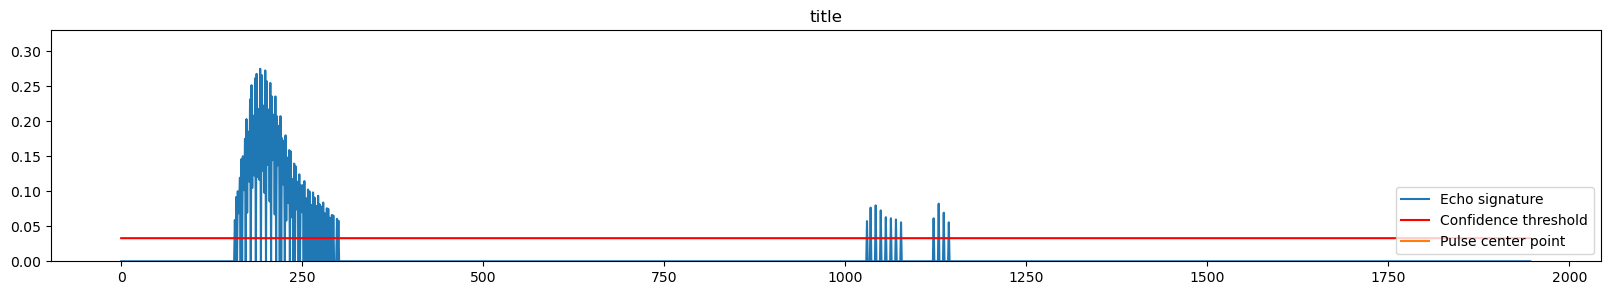

Output space indexes:  []
Pulse center point:  194
Echo center point:  [894, 1351]


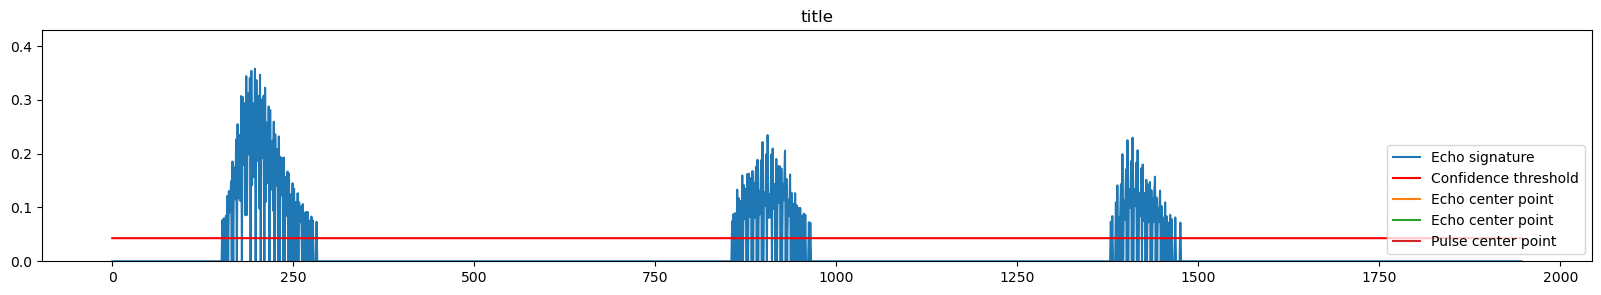

Echo distance 0 -> 0.8575 [m]
Echo distance 1 -> 1.417325 [m]
Output space indexes:  [34, 56]
Pulse center point:  189
Echo center point:  [862, 942]


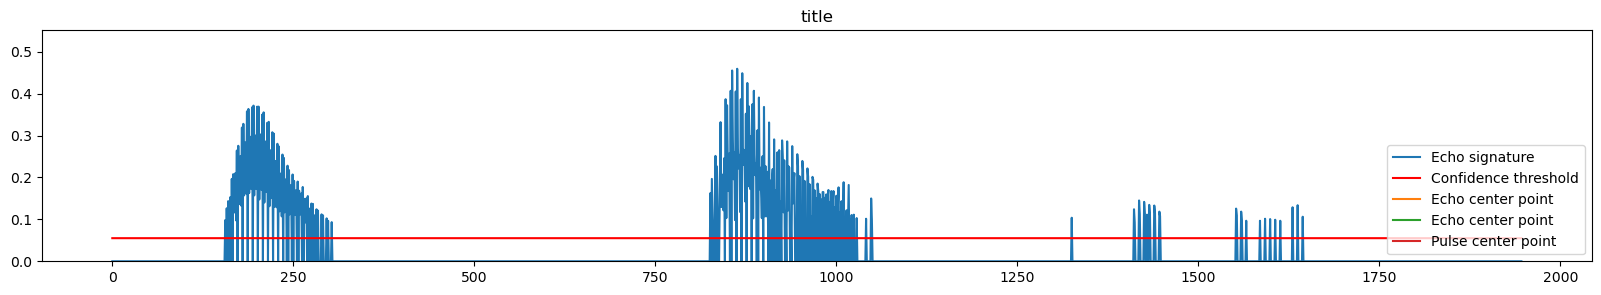

Echo distance 0 -> 0.824425 [m]
Echo distance 1 -> 0.922425 [m]
Output space indexes:  [32, 36]


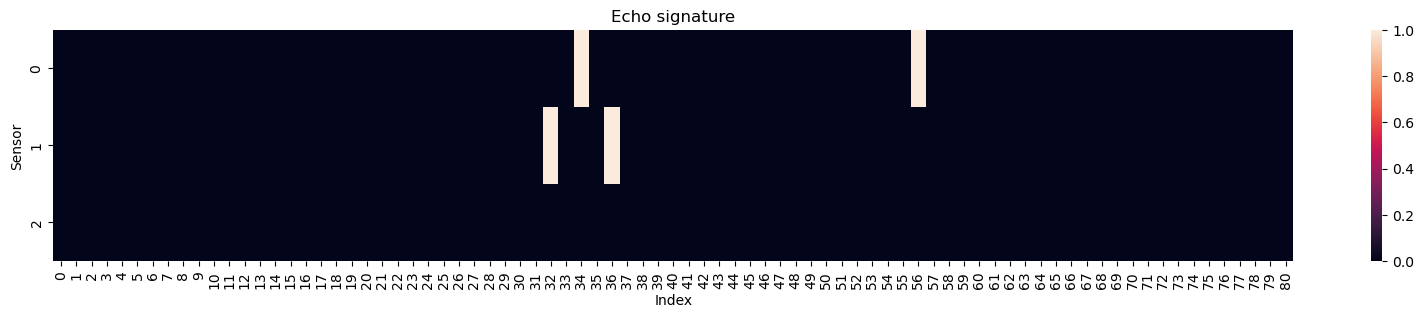

In [22]:
curated_data = np.zeros([N_SENSORS, 81])
plot_processing = False

for j in range(N_SENSORS):
    
    ## Define sample to analize
    
    sample = received_data[j-1, 100:].astype(float)
    
    ## Apply derivate and noise reduction techniques
    
    sample_denoised = helpers.derivate_and_noise_reduction(sample, plot_processing)
   
    ## Detect pulses and retrieve related sample indexes
    
    center_point_pulse, center_point = helpers.pulse_detection(sample_denoised, print_results = True)

    ## Transform sample dimention to match ML algorithm input dimention
    
    output_space = helpers.dimention_transformation(center_point_pulse, center_point, print_results = True)
    
    ## Replace calculated indexes in the final array
    for pulse_idx in output_space:
        curated_data[j-1, pulse_idx] = 1

    print('Output space indexes: ',output_space)

sns.heatmap(curated_data[:, :])
plt.xlabel('Index')
plt.ylabel('Sensor')
plt.title('Echo signature')
plt.show()

### Inference test

Load ML model

In [16]:
#load model from path
path_to_load = '../models/model_v2.h5'
#define needed dependecies to load the model
dependencies = {
    'f1_m': f1_m
}
#load the model
classifier = load_model(path_to_load, custom_objects=dependencies, compile=False )

Original input data shape:  (3, 81)
New input data shape:  (1, 243)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Predicted object quadrant:  [146]


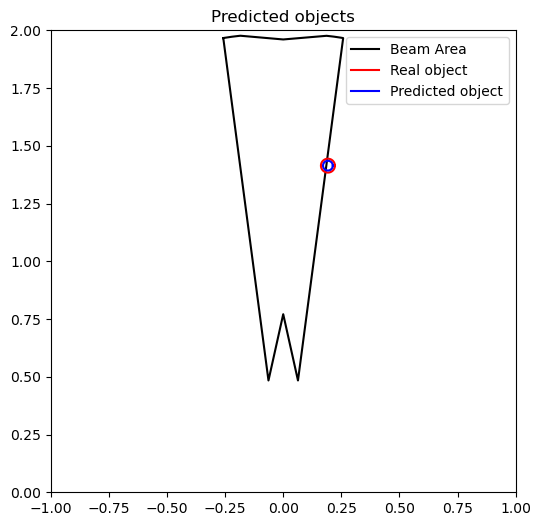

In [41]:
### Reshape 3D data into 2D array
print("Original input data shape: ", curated_data.shape)

#model_input  = curated_data.reshape(curated_data.shape[0],(curated_data.shape[1] * curated_data.shape[2]))

model_input = curated_data.reshape(curated_data.shape[0] * curated_data.shape[1])
flattened_data = curated_data.flatten()
model_input = flattened_data[np.newaxis, :]

print("New input data shape: ", model_input.shape)

### Make predictions
X_val = model_input  #Values to predict

#define a threshold value 
threshold = 0.1
#ANN prediction
y_pred = classifier.predict(X_val)
#keep predictions above the threshold
y_pred = (y_pred > threshold)

for pred in range(len(y_pred)):

    print('\nPredicted object quadrant: ',
          np.argwhere(np.isin(y_pred[pred], True)).ravel())
    
    predicted_points = np.argwhere(np.isin(y_pred[pred], True)).ravel()



    plt.rcParams["figure.figsize"] = (6,6)
    object_location.test(predicted_points, predicted_points)
